In [1]:
from skimage.io import imread
from sklearn.neighbors import KDTree
from sklearn.cluster import KMeans
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os
sys.path.insert(0, '../../../../FISH-annotation/fishanno')
import util
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from QuantiusAnnotation import QuantiusAnnotation
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
img_filename = 'snr_5_0_density_0.006_spot_img.png'
img_filepath = './datasets/%s' % img_filename
csv_filepath = './datasets/snr_5_0_density_0.006_coord_snr_list.csv'
json_filepath = './datasets/Spot_density.json'
clustering_params = ['AffinityPropagation', -350]
img_height = len(imread(img_filepath))

In [3]:
qa = QuantiusAnnotation(json_filepath, img_filename)
sa = SpotAnnotationAnalysis(qa)
anno_all = qa.df()
clusters = sa.get_clusters(anno_all, clustering_params)        

In [4]:
cluster_size_threshold = util.get_cluster_size_threshold(clusters)
small_clusters, large_clusters = util.sort_clusters_by_size(clusters, cluster_size_threshold)

In [5]:
# For each cluster, calc and sort replication of each worker
actual_clumps = []
not_actual_clumps = []
incorrect_clusters = []

for i in range(len(large_clusters.index)):
    row = large_clusters.iloc[[i]]
    members = row.iloc[0]['members']
    workers = []
    x_coords = []
    y_coords = []

    for member in members:
        x_coords.append(member[0])
        y_coords.append(member[1])
        workers.append(member[3])
    
    # Calculate replication of unique workers for each cluster
    unique_workers = np.unique(workers)
    num_instances_list = []
    for unique_worker in unique_workers:
        num_instances_list.append(workers.count(unique_worker))
    singles = num_instances_list.count(1)
    single_fraction = singles/len(unique_workers)

    # Are there at least two ref spots in the area of this cluster? (Is this cluster actually clumpy?)  
    centroid_coord = [row.iloc[0]['centroid_x'], row.iloc[0]['centroid_y']]
    ref_kdt = util.csv_to_kdt(csv_filepath, img_height)
    dist, ind = ref_kdt.query([centroid_coord],k=2)
    index_0 = ind[0][0]
    index_1 = ind[0][1]
    ref_array = np.asarray(ref_kdt.data)
    neighbor_0 = ref_array[index_0]
    neighbor_1 = ref_array[index_1]
    if(dist[0][0] <= 4):
        if ((neighbor_0[0] >= min(x_coords)) and (neighbor_0[0] <= max(x_coords)) and
            (neighbor_0[1] >= min(y_coords)) and (neighbor_0[1] <= max(y_coords)) and 
            (neighbor_1[0] >= min(x_coords)) and (neighbor_1[0] <= max(x_coords)) and
            (neighbor_1[1] >= min(y_coords)) and (neighbor_1[1] <= max(y_coords))):
            actual_clumps.append(single_fraction)
        else:
            not_actual_clumps.append(single_fraction)
    else:
        incorrect_clusters.append(single_fraction)


In [6]:
threshold = util.get_clumpiness_threshold(large_clusters)

In [7]:
non_clumpy_color = '#fadadd'
clumpy_color = '#f88379'

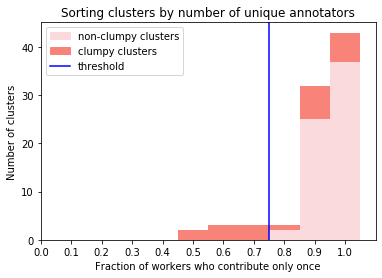

In [20]:
width = 2
plt.figure()
plt.hist([not_actual_clumps, actual_clumps], bins=np.arange(-0.05,1.25,0.1), stacked=True, color=[non_clumpy_color, clumpy_color])
plt.axvline(x=threshold, color='b')
non_clumpy_patch = mpatches.Patch(color=non_clumpy_color, label='non-clumpy clusters')
clumpy_patch = mpatches.Patch(color=clumpy_color, label='clumpy clusters')
kmeans_line = Line2D([0],[0], color='b', label='threshold')

plt.legend(handles=[non_clumpy_patch, clumpy_patch, kmeans_line])
plt.xticks(np.arange(0,1.1, 0.1))
plt.xlim(0,1.1)
plt.xlabel('Fraction of workers who contribute only once')
plt.ylabel('Number of clusters')
plt.title('Sorting clusters by number of unique annotators')
plt.savefig("fig_2b.pdf", transparent=True, bbox_inches='tight')
plt.show()

In [9]:
clumpy_clusters, nonclumpy_clusters = util.sort_clusters_by_clumpiness(clusters, threshold)

In [10]:
ref = np.asarray(pd.read_csv(csv_filepath))
im = imread(img_filepath, as_gray=True)
img_height = len(im)
margin = 10

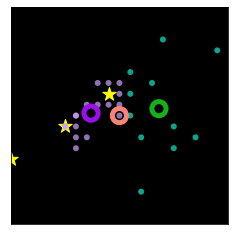

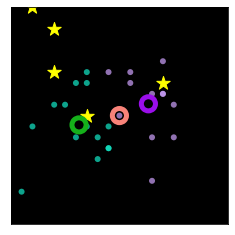

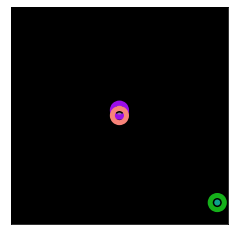

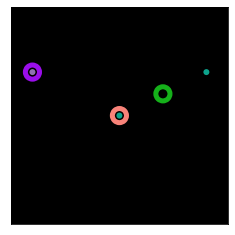

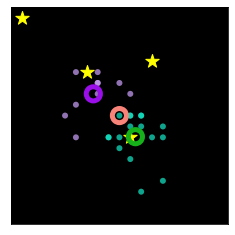

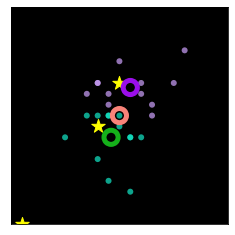

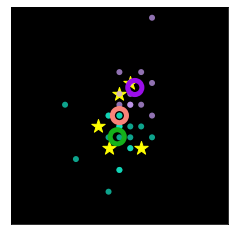

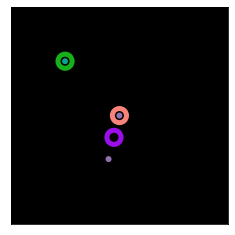

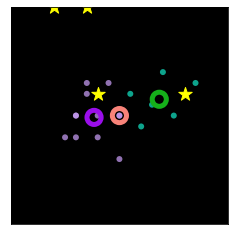

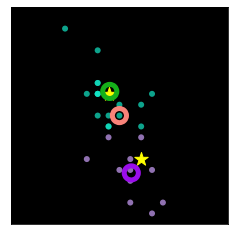

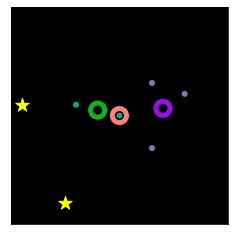

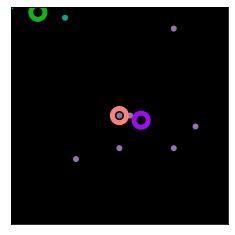

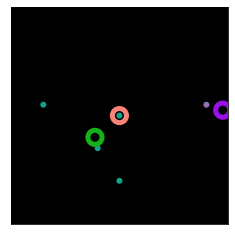

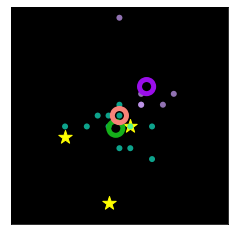

In [19]:
for clump_index in range(len(clumpy_clusters)):
    centroid_x = np.asarray(clumpy_clusters[['centroid_x']].iloc[clump_index])[0]
    centroid_y = np.asarray(clumpy_clusters[['centroid_y']].iloc[clump_index])[0]
    clump = np.asarray(clumpy_clusters[['members']].iloc[clump_index])[0]

    members = []
    for member_index in range(len(clump)):
        x, y, time, ID = clump[member_index]
        members.append([x, y])

    km = KMeans(n_clusters=2).fit(members)
    centers = km.cluster_centers_
    labels = km.labels_

    fig,ax = plt.subplots(1)
    for x, y, snr in ref:
        plt.scatter([x], [img_height-y], facecolors='yellow', marker='*', s=200)
    for member, label in zip(members, labels):
        color = 'xkcd:lilac' if label else 'xkcd:aqua'
        plt.scatter([member[0]], [member[1]], facecolors=color, edgecolors='None', alpha=0.7)
    
    plt.scatter(centers[0][0], centers[0][1], facecolors='None', edgecolors= 'xkcd:green', s=200, linewidth=5)
    plt.scatter(centers[1][0], centers[1][1], facecolors='None', edgecolors='xkcd:violet', s=200, linewidth=5)

    plt.scatter([centroid_x], [centroid_y], facecolors='None', edgecolors=clumpy_color, s=200, linewidth=5)
    plt.xlim(centroid_x-margin, centroid_x+margin)
    plt.ylim(centroid_y-margin, centroid_y+margin)
    plt.xticks([])
    plt.yticks([])
    plt.gca().set_aspect('equal', adjustable='box')
    ax.set_facecolor('black')
#     plt.imshow(im, cmap='gray')
    plt.savefig("clump%s.pdf" % clump_index, transparent=False, bbox_inches="tight")
    plt.show()